<a href="https://www.kaggle.com/code/chalseo/bank-churn-binary-classification?scriptVersionId=159372254" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

print("Features: ", "\n", train_data.columns.values)
print("\n", "Train data shape: ", train_data.shape)
print("\n", "Test data shape: ", test_data.shape)

Features:  
 ['id' 'CustomerId' 'Surname' 'CreditScore' 'Geography' 'Gender' 'Age'
 'Tenure' 'Balance' 'NumOfProducts' 'HasCrCard' 'IsActiveMember'
 'EstimatedSalary' 'Exited']

 Train data shape:  (165034, 14)

 Test data shape:  (110023, 13)


In [3]:
numerical_features = ['Age', 'Balance', 'CreditScore',  'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
train_data = train_data.drop_duplicates()
train_data[numerical_features + ['Exited']].describe(percentiles=[]).T.drop(columns=['count'])

,mean,std,min,50%,max
Age,38.125888,8.867205,18.00,37.0,92.00
Balance,55478.086689,62817.663278,0.00,0.0,250898.09
CreditScore,656.454373,80.103340,350.00,659.0,850.00
EstimatedSalary,112574.822734,50292.865585,11.58,117948.0,199992.48
HasCrCard,0.753954,0.430707,0.00,1.0,1.00
IsActiveMember,0.497770,0.499997,0.00,0.0,1.00
NumOfProducts,1.554455,0.547154,1.00,2.0,4.00
Tenure,5.020353,2.806159,0.00,5.0,10.00
Exited,0.211599,0.408443,0.00,0.0,1.00


In [4]:
categorical_features = ['Geography', 'Gender']
train_data[categorical_features].describe().T.drop(columns=['count'])

,unique,top,freq
Geography,3,France,94215
Gender,2,Male,93150


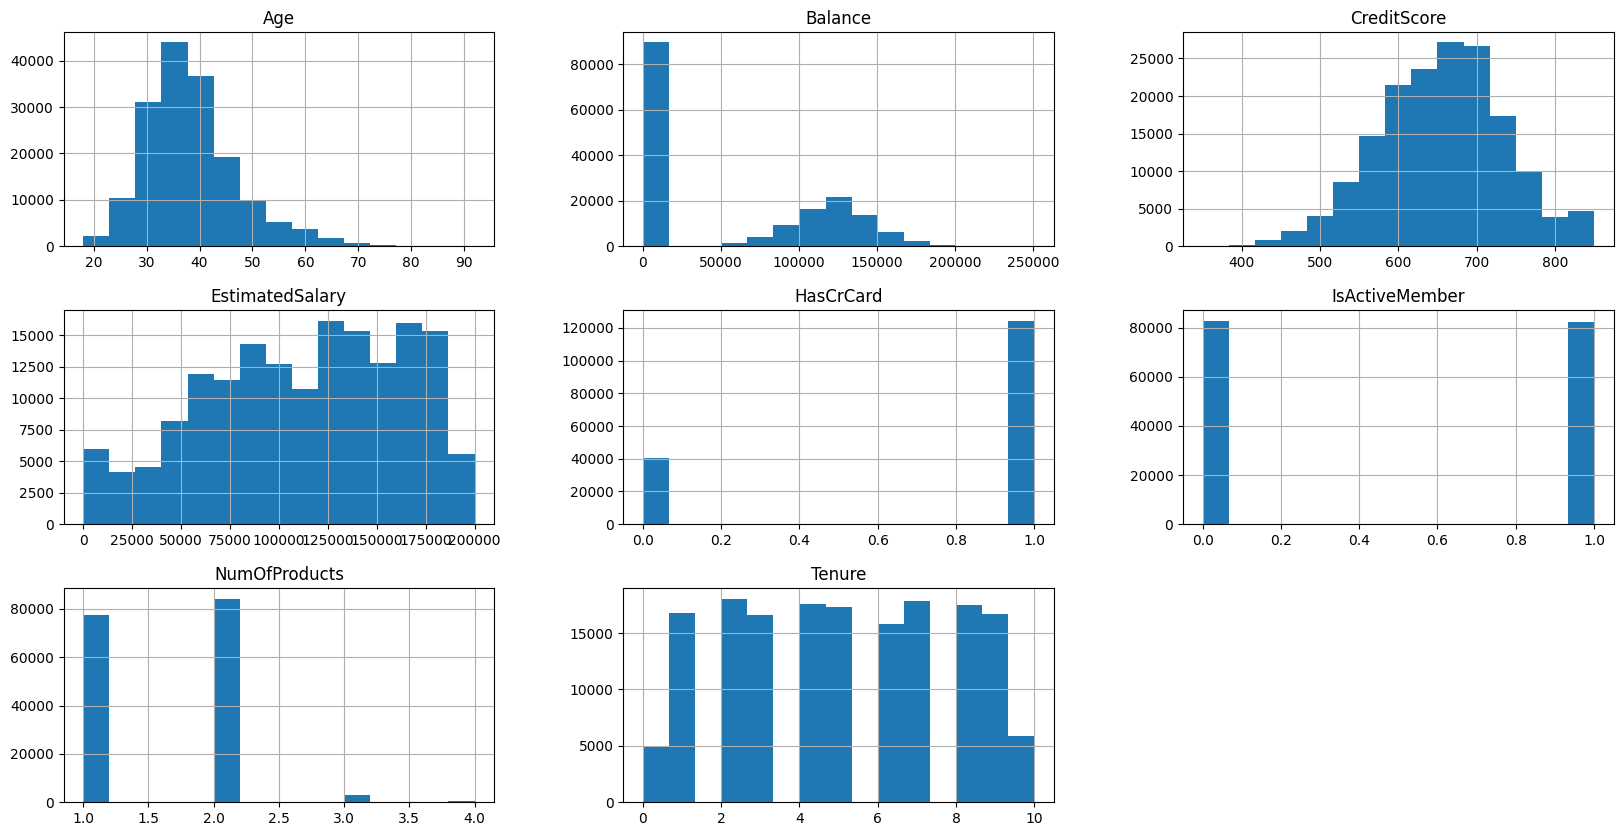

In [5]:
train_data.hist(column=numerical_features, figsize=(20,10), bins=15)
plt.show()

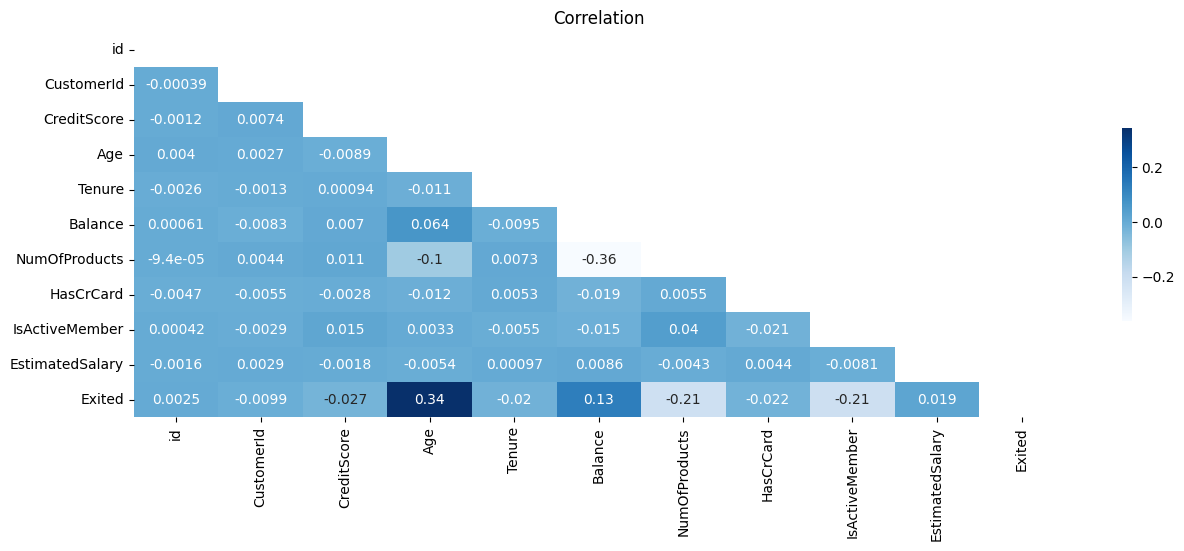

In [6]:
corr = train_data.corr(numeric_only=True)
plt.figure(figsize=(15, 5))
sns.heatmap(corr, mask=np.triu(corr), annot=True, cmap='Blues', cbar_kws={"shrink": .5})
plt.title("Correlation")
plt.show()

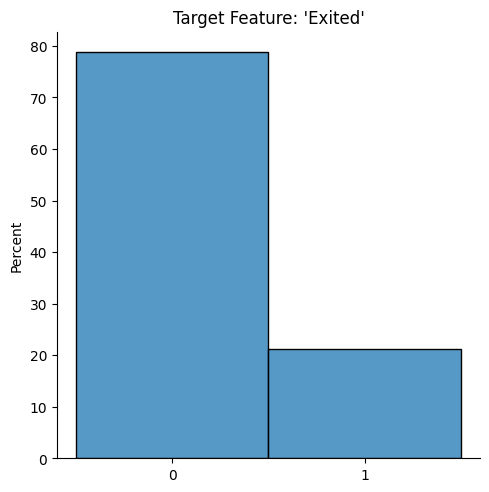

In [7]:
sns.displot(train_data.Exited.astype('str'), stat='percent', legend=True)
plt.title("Target Feature: 'Exited'")
plt.xlabel(None)
plt.show()

In [8]:
train_data = train_data.drop(columns=["id", "CustomerId", "Surname"])
test_data = test_data.drop(columns=["id", "CustomerId", "Surname"])

train_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [9]:
categorical_features = categorical_features
numerical_features = numerical_features

transformer = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), sparse_threshold=0)
transformed_data = transformer.fit_transform(train_data)

feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]
X = pd.DataFrame(transformed_data, columns=feature_names)
y = train_data['Exited']

transformed_data = transformer.fit_transform(test_data)
X_pred = pd.DataFrame(transformed_data, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
print("Features: ", "\n", X_train.columns.values)

Features:  
 ['Age' 'Balance' 'CreditScore' 'EstimatedSalary' 'HasCrCard'
 'IsActiveMember' 'NumOfProducts' 'Tenure' 'Geography_France'
 'Geography_Germany' 'Geography_Spain' 'Gender_Female' 'Gender_Male']


In [10]:
clf = RandomForestClassifier(oob_score=True, n_jobs=-1,random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
oob = clf.oob_score_

print("AUC score: %.2f%%" % (auc * 100.0))
print("oob score: %.2f%%" % (oob * 100.0))
print("\n", classification_report(y_test, y_pred))

AUC score: 74.12%
oob score: 85.65%

               precision    recall  f1-score   support

           0       0.89      0.94      0.91     39133
           1       0.72      0.54      0.62     10378

    accuracy                           0.86     49511
   macro avg       0.80      0.74      0.76     49511
weighted avg       0.85      0.86      0.85     49511



In [11]:
# CV

In [12]:
# Retrain model

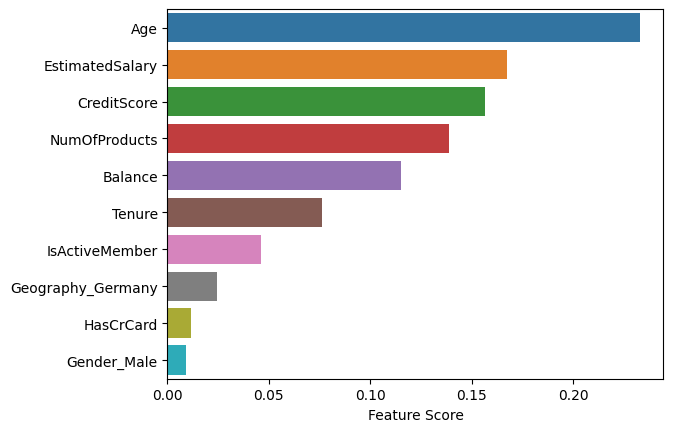

In [13]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns, name='Feature Score').nlargest(10)
feature_importances = feature_importances.sort_values(ascending=False).reset_index()

sns.barplot(feature_importances, x='Feature Score', y='index')
plt.ylabel(None)
plt.show()

In [14]:
# Create submission .csv file